# 1. Data Loading

In [ ]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 2. Package imports

In [1]:
import json
import functools
import operator
from typing import List, Dict, Any
import os
import re
from PIL import Image, ImageDraw, ImageFont
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import plotly.graph_objects as go
from tqdm import tqdm

import easyocr
from sklearn.model_selection import train_test_split

/Users/astel/mambaforge/envs/torch-env/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/astel/mambaforge/envs/torch-env/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /Users/astel/mambaforge/envs/torch-env/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/astel/mambaforge/envs/torch-env/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/astel/mambaforge/envs/torch-env/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/astel/mambaforge/envs/torch-env/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/astel/mambaforge/envs/torch-env/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Othe

# 3. Examples
## 3.a. Open a single image

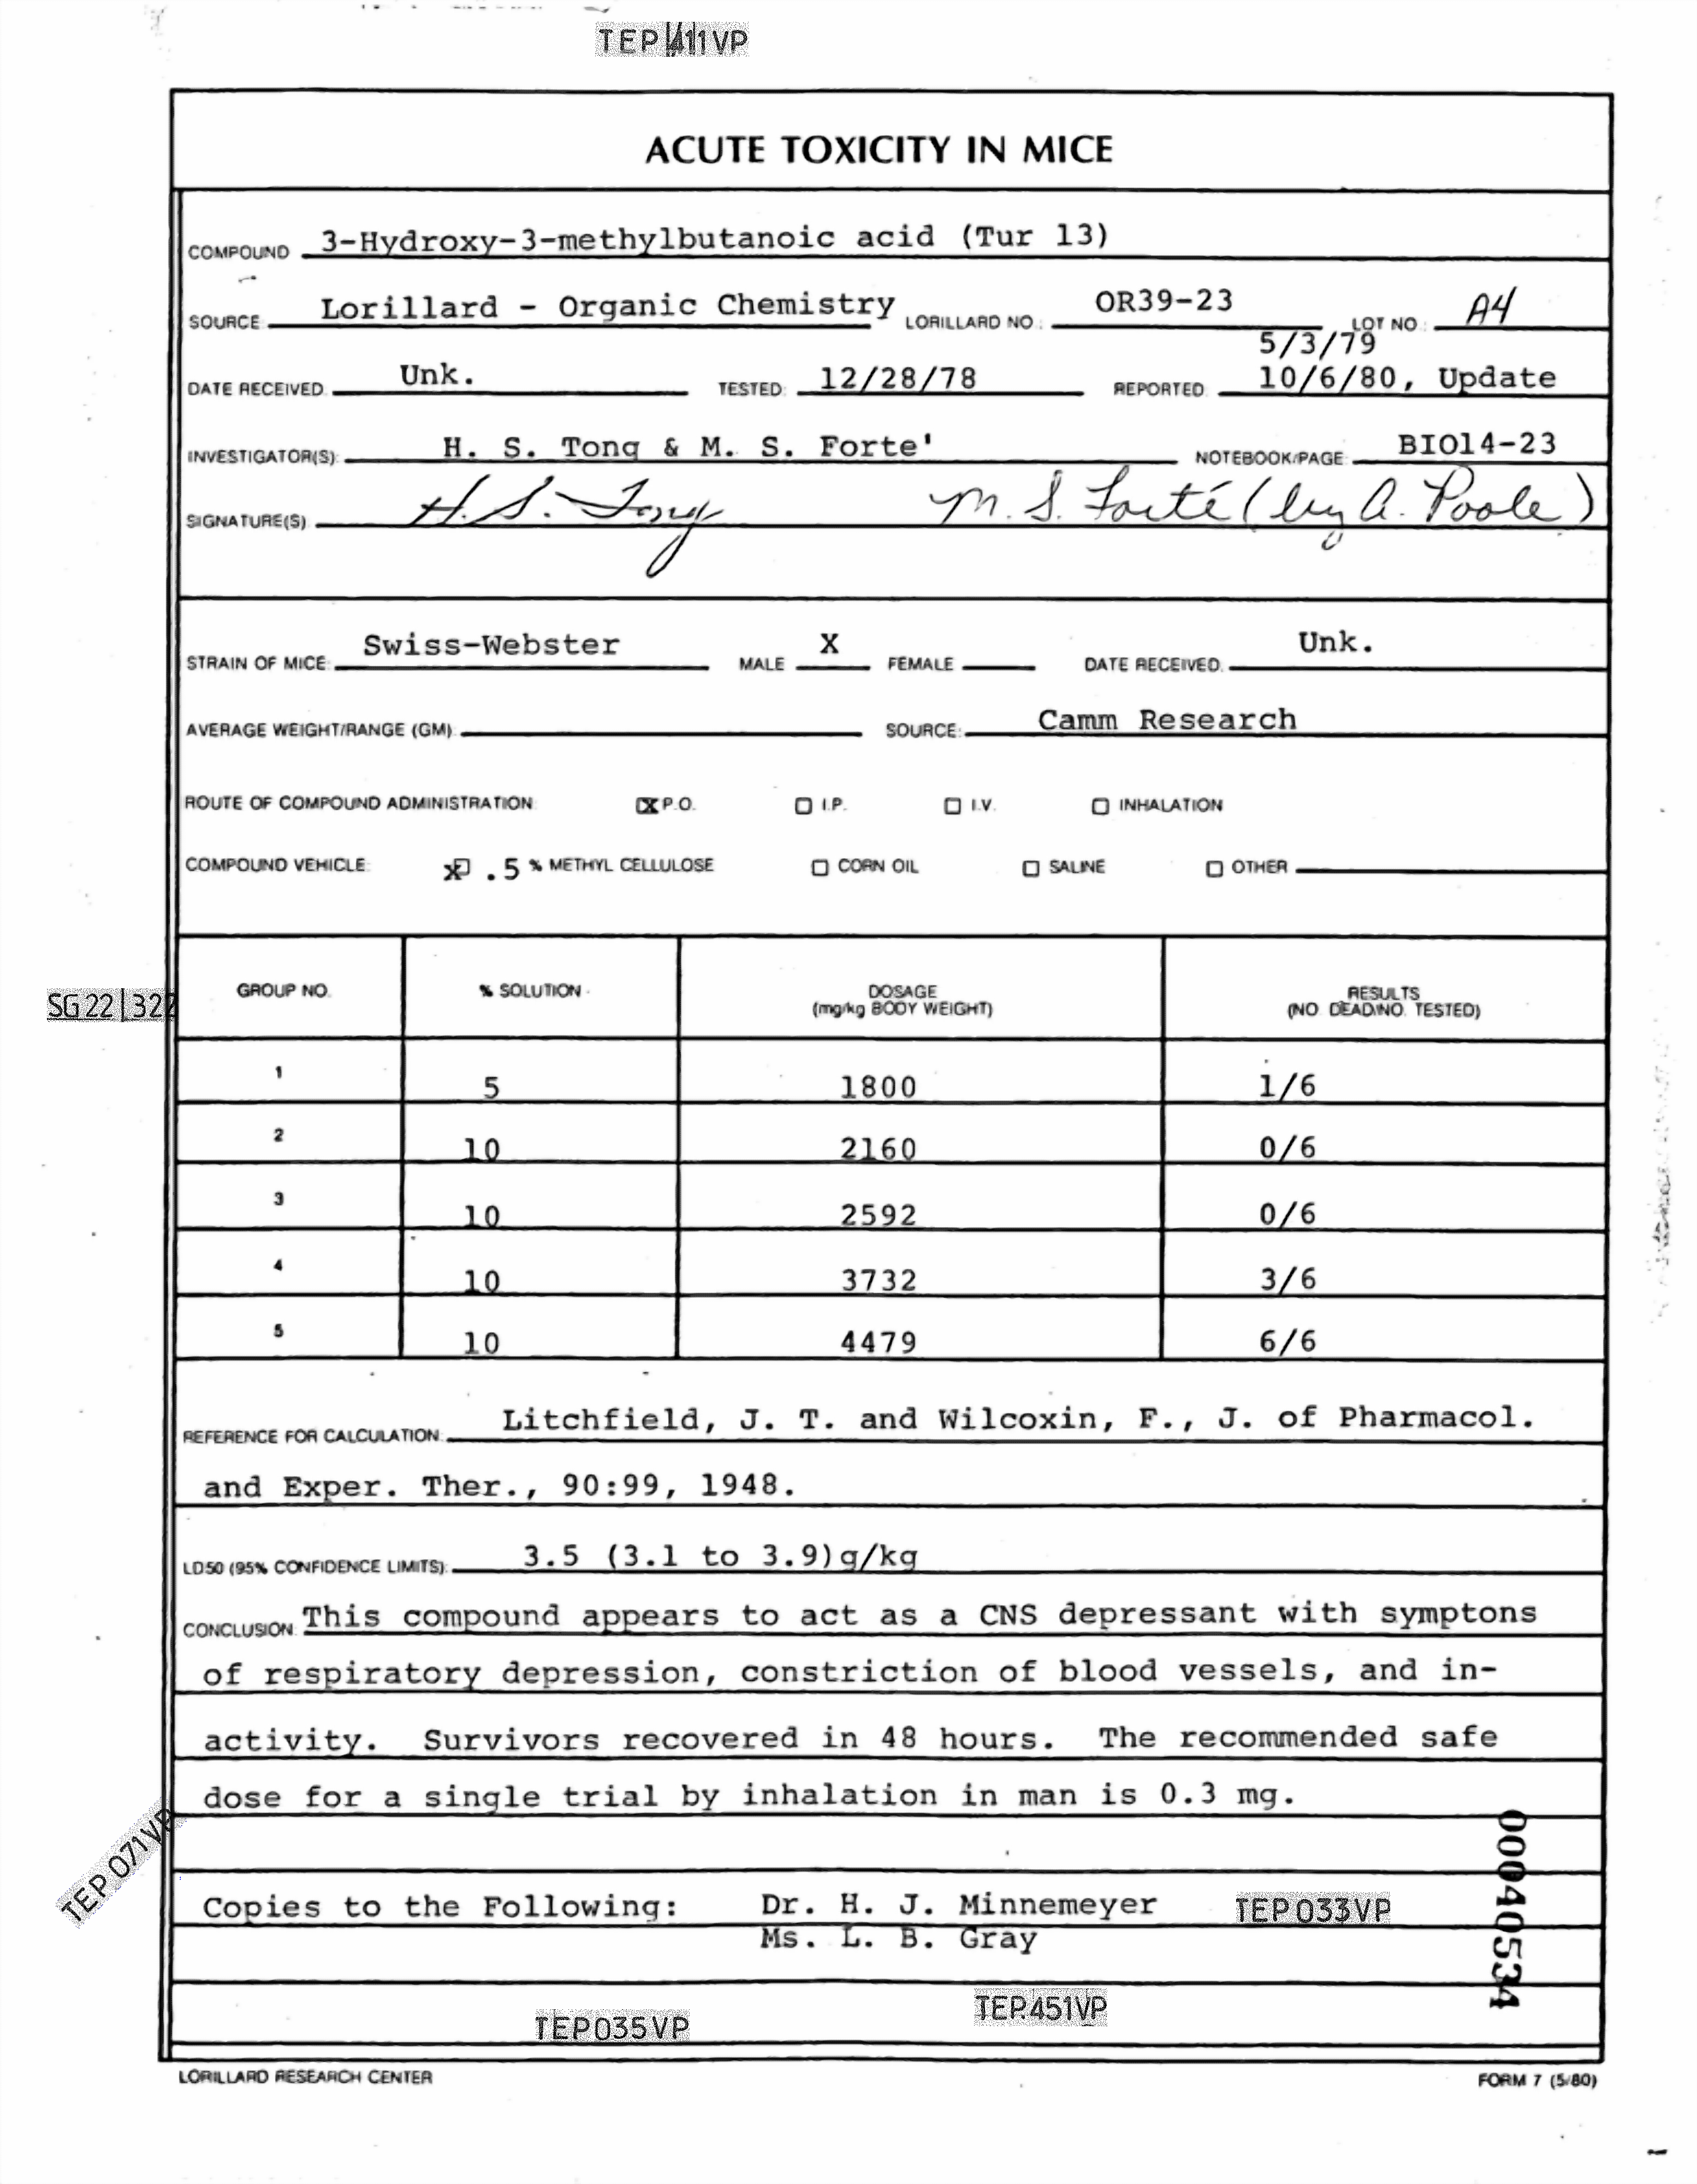

In [43]:
id = '00040534'
image_path = f'intelligent-text-extraction/train/images/{id}.png'
with open(f'intelligent-text-extraction/train/annotations/{id}.json', 'r') as f:
    annotation = json.load(f)
image = Image.open(image_path)
image

## 3.b. Display the bounding box

In [ ]:
def draw_boxes(image:Image, annotation:dict) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        text = dict_box['text']
        (x_min, y_min, x_max, y_max) = dict_box['box']
        if x_min < x_max and y_min< y_max:
            # Draw rectangle
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            # Add text
            draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
        else:
            print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

In [ ]:
# Display the image with bounding boxes
draw_boxes(image, annotation)

## 3.c. Select only the 'RF' boxes

In [ ]:
# Define a function to draw boxes only if the label correspond to the input
def draw_specific_boxes(image:Image, annotation:dict, specific_label:str) -> Image:
    # Create a drawing context
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    # Load a font
    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')    
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)
    
    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        label = dict_box['label']
        if label == specific_label:
            text = dict_box['text']
            (x_min, y_min, x_max, y_max) = dict_box['box']
            if x_min < x_max and y_min< y_max:
                # Draw rectangle
                draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
                # Add text
                draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
            else:
                print(f"Bounding box is invalid: {dict_box['box']}")
    return image_with_boxes

In [ ]:
draw_specific_boxes(image, annotation, 'RF')

##### 

# 4. Example of OCR prediction : easyOCR

In [ ]:
def analyze_image(image_path:str, language:str='en') -> list:
    """
    Analyze the image to detect text using EasyOCR.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    list: A list of tuples containing the bounding box, detected text, and confidence score for each detected text region.
    """
    # Create a Reader object for text detection
    reader = easyocr.Reader([language], gpu=True)  # You can activate/deactivate GPU
    
    # Read the text from the image
    resultats = reader.readtext(image_path)
    
    return resultats

In [ ]:
def transform_result(results: List[Dict[str, Any]]) -> str:
    """
    Transforms OCR results into Challenge's JSON format.

    Args:
        results (List[Dict[str, Any]]): A list of OCR results where each result is a dictionary containing:
            - bbox (List[List[int]]): Bounding box coordinates.
            - text (str): Detected text.
            - prob (float): Confidence score.

    Returns:
        str: A JSON string representing the transformed OCR results.
    """
    form_data = []
    for idx, (bbox, text, prob) in enumerate(results):
        # Convert bounding box coordinates to integers
        bbox = [[int(coord) for coord in point] for point in bbox]
        box_extracted = [bbox[0], bbox[2]]
        flat_box = [coord for sublist in box_extracted for coord in sublist]
        
        # Create the structure for each element
        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  #### WARNING : Customize this field as needed !
            "words": [{"box": flat_box, "text": text}],  # Each word is encapsulated in a 'words' list
            "linking": [],  # This part can be used to link words if necessary
            "id": idx
        }
        
        form_data.append(item)

    # Convert to JSON
    json_data = {
        "form": form_data
    }

    # Convert JSON data to a formatted string
    #json_output = json.dumps(json_data, indent=4, ensure_ascii=False)
    return json_data

In [ ]:
results = transform_result(analyze_image(image_path))
print(results)

In [ ]:
draw_specific_boxes(image, results, 'RF')

# 5. Compute score

You need to put the true annotations in a folder and your predictions in another folder to compute results

In [ ]:
# Create a folder to store JSON predictions
output_folder = 'output_easyocr'
# !mkdir -p {output_folder}
os.makedirs(output_folder, exist_ok=True)

# Create a folder to store ground truth JSON
ground_truth_folder = 'ground_truth_annotations'
# !mkdir -p {ground_truth_folder}
os.makedirs(ground_truth_folder, exist_ok=True)

In [ ]:
# Save predictions
json_output = json.dumps(results, indent=4, ensure_ascii=False)
with open(f'{output_folder}/{id}.json', 'w', encoding='utf-8') as f:
    f.write(json_output)

# Save true annotations
input_path = f'intelligent-text-extraction/train/annotations/{id}.json'
output_path = f'{ground_truth_folder}/{id}.json'

with open(input_path, 'r', encoding='utf-8') as file:
    annotation = json.load(file)

# Write the annotation JSON to the ground truth folder
with open(output_path, 'w', encoding='utf-8') as f:
    json.dump(annotation, f, ensure_ascii=False, indent=4)  # Properly write JSON


In [ ]:
# Utils functions to compute result

def clean_txt(s: str) -> str:
    return re.sub(r'[^A-Z0-9]+', '', s.upper())


get_rects = functools.partial(map, operator.itemgetter('box'))
get_texts = functools.partial(map, operator.itemgetter('text'))


def compute_overlap(gt: np.array, preds: np.array) -> np.array:
    _gt = np.tile(np.expand_dims(gt, axis=1), (1, preds.shape[0], 1))
    _p = np.tile(np.expand_dims(preds, axis=0), (gt.shape[0], 1, 1))

    dx = np.minimum(_gt[:, :, 2], _p[:, :, 2]) - np.maximum(_gt[:, :, 0], _p[:, :, 0])
    dy = np.minimum(_gt[:, :, 3], _p[:, :, 3]) - np.maximum(_gt[:, :, 1], _p[:, :, 1])

    area = dx * dy
    # valid area if dx > 0 and dy > 0
    overlap = np.where(np.logical_and(dx > 0, dy > 0), area, 0)

    return overlap


def compute_area(rects: np.array) -> np.array:
    return (rects[:, 2] - rects[:, 0]) * (rects[:, 3] - rects[:, 1])


def compute_iou(gt: np.array, preds: np.array) -> np.array:
    gt_area = compute_area(gt)
    p_area = compute_area(preds)

    _gt_area = np.tile(gt_area[:, np.newaxis], (1, preds.shape[0]))
    _p_area = np.tile(p_area[np.newaxis, ], (gt.shape[0], 1))

    overlap = compute_overlap(gt, preds)

    _iou = overlap / (_gt_area + _p_area - overlap)

    return np.amax(_iou, axis=1), np.argmax(_iou, axis=1)


def compute_correct_rf(gt_texts: list, preds_texts: list, iou_results, iou_threshold=0.25) -> int:
    iou, best_iou_id = iou_results
    n_corrects = 0
    for i_txt, text in enumerate(gt_texts):
        if clean_txt(text) in clean_txt(preds_texts[best_iou_id[i_txt]]) and iou[i_txt] > iou_threshold:
            n_corrects += 1

    return n_corrects


def compute_results(gt: list, preds: list):
    gt = list(filter(lambda x: x['label'] == 'RF', gt))
    gt_rects = np.array(list(get_rects(gt)))
    gt_texts = list(get_texts(gt))

    p_rects = np.array(list(get_rects(preds)))
    p_texts = list(get_texts(preds))

    n_gt_rects = len(gt_rects)

    if n_gt_rects == 0:
        return 1.0, 1.0

    iou, best_iou_id = compute_iou(gt_rects, p_rects)
    # print("IOU: ", iou)
    # print("Best IOU ID: ", best_iou_id)
    n_corrects = compute_correct_rf(gt_texts, p_texts, (iou, best_iou_id))

    return np.sum(iou)/n_gt_rects, n_corrects/n_gt_rects

In [ ]:
def compute_result(ground_truth, predictions):
    means_ious = []
    means_rf = []

    for file in os.listdir(ground_truth):
        with open(os.path.join(ground_truth, file), 'rb') as f:
            gt_json = json.load(f)

        pred_file = os.path.join(predictions, file)
        if os.path.isfile(pred_file):
            with open(pred_file, 'rb') as f:
                preds_json = json.load(f)

        else:
            means_ious.append(0)
            means_rf.append(0)
            continue

        file_iou, file_rf = compute_results(
            gt_json['form'],
            preds_json['form']
        )
        means_ious.append(file_iou)
        means_rf.append(file_rf)
    print(f"IOU: {np.mean(means_ious) * 100:.2f}")
    print(f"RF Correct: {np.mean(means_rf) * 100:.2f}")
    return means_ious, means_rf


In [ ]:
gt_folder = os.path.join(os.getcwd(), ground_truth_folder)
pred_folder = os.path.join(os.getcwd(), output_folder)

iou, rf = compute_result(gt_folder, pred_folder)

# 6. From json to csv format

You need to create csv and make sure commas are replaced by semi-commas.

In [ ]:
import os
import json
import pandas as pd

# Initialize an empty list to store the form data
form_data_list = []
ids = []
# Iterate through each file in the directory
for filename in os.listdir(output_folder):
    if filename.endswith('.json'):
        file_path = os.path.join(output_folder, filename)
        with open(file_path, 'r') as file:
            data = json.load(file)
            form_data_list.append(data['form'])
            ids.append(filename.split('.')[0])
# Create a DataFrame from the form data list
target_form = pd.DataFrame()
target_form['id'] = ids
target_form['target'] = form_data_list
target_form['target'] = target_form['target'].astype(str)
target_form = target_form.replace(',', ';', regex=True)  # Here we replace , by ;
target_form['Usage'] = 'Public'


In [ ]:
target_form.to_csv('sample_submission.csv', index=False, sep=',')

# Tests

In [4]:
import cv2
import numpy as np

# Charger l'image en niveaux de gris
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Appliquer un seuillage adaptatif pour améliorer le contraste
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# Appliquer une ouverture morphologique pour réduire le bruit
kernel = np.ones((3,3), np.uint8)
morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# Trouver les contours des objets textuels
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Charger l'image en couleur pour affichage des boxes
image_color = cv2.imread(image_path)

# Filtrer et dessiner les contours selon leur taille
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 50 and h > 10:  # Ajuster ces valeurs selon la taille des codes RF
        cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Afficher le résultat
cv2.imshow("Zones detectees", image_color)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

In [34]:
import cv2
import numpy as np

# Charger l'image en niveaux de gris
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Appliquer un filtre Laplacien pour détecter les zones de fort contraste
laplacian = cv2.Laplacian(image, cv2.CV_64F, ksize=3)
laplacian = np.uint8(np.absolute(laplacian))

# Appliquer un filtre Sobel pour renforcer les contours
sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
sobel = cv2.magnitude(sobelx, sobely)
sobel = np.uint8(np.absolute(sobel))

# Renforcer uniquement les bords les plus marqués
edges = cv2.addWeighted(laplacian, 0.7, sobel, 0.3, 0)

# Appliquer un seuillage Otsu strict
_, binary = cv2.threshold(edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Éliminer le bruit et connecter les caractères avec une fermeture morphologique plus agressive
kernel = np.ones((2, 2), np.uint8)
morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=3)

# Détection des contours
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Charger l'image en couleur pour affichage des bounding boxes
image_color = cv2.imread(image_path)

# Filtrer les zones les plus nettes avec des critères plus stricts
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 60 and h > 15:  # Ajustement pour ne garder que les zones nettes et bien définies
        cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Enregistrer l'image avec les zones détectées
cv2.imwrite("resultat_nettete.png", image_color)

print("Image enregistrée sous 'resultat_nettete.png'")


Image enregistrée sous 'resultat_nettete.png'


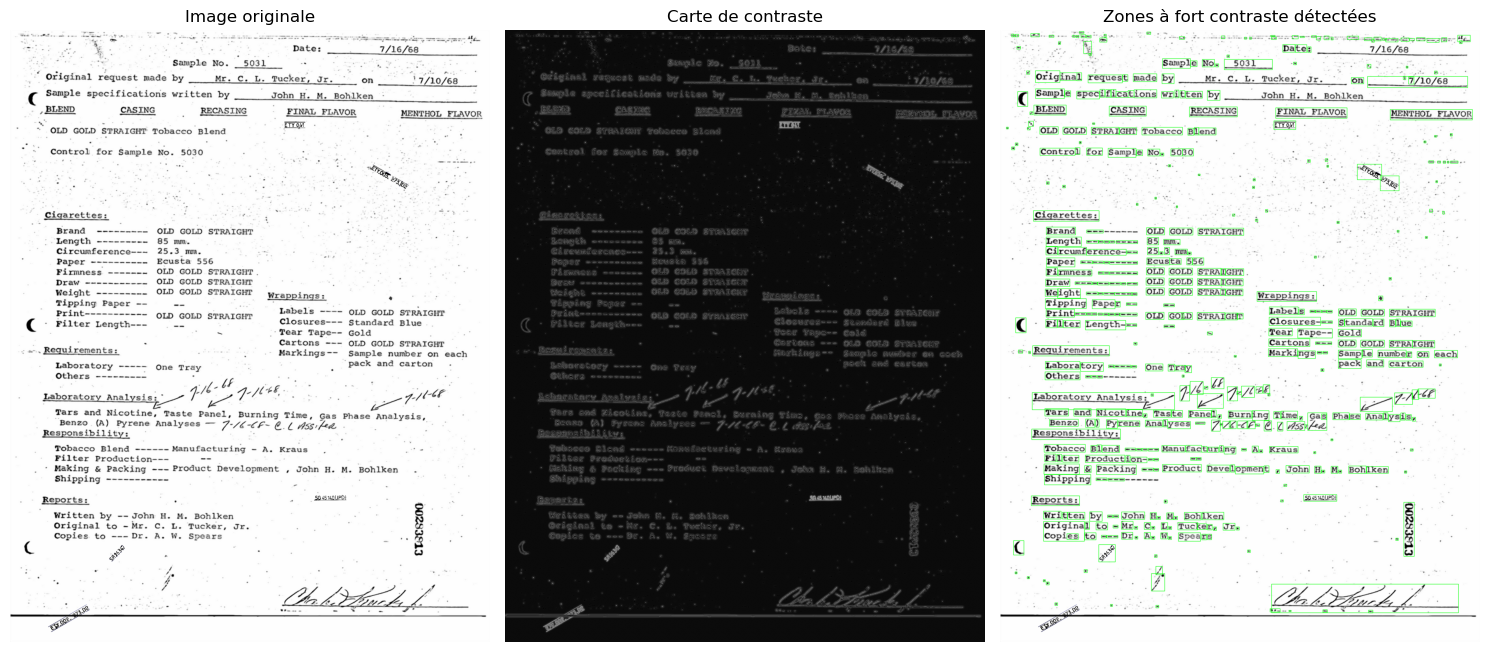

Résultat sauvegardé dans resultat_detection.png


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.measure import label, regionprops

def detect_high_contrast_text(image_path, output_path=None):
    """
    Détecte et encadre les zones de texte à fort contraste dans une image.
    
    Args:
        image_path (str): Chemin vers l'image d'entrée
        output_path (str, optional): Chemin pour sauvegarder l'image résultante
        
    Returns:
        tuple: Image originale et image avec les zones encadrées
    """
    # Chargement de l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")
    
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calcul du contraste local
    window_size = 25
    local_thresh = threshold_local(gray, window_size, offset=10, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)
    
    # Normalisation du contraste pour visualisation
    contrast_norm = (contrast / np.max(contrast) * 255).astype(np.uint8)
    
    # Seuillage pour obtenir les zones à fort contraste
    thresh_value = np.percentile(contrast, 90)  # Ajustez ce seuil selon vos besoins
    high_contrast = contrast > thresh_value
    
    # Filtrage morphologique pour nettoyer les zones détectées
    kernel = np.ones((3, 3), np.uint8)
    high_contrast = cv2.morphologyEx(high_contrast.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    high_contrast = cv2.morphologyEx(high_contrast, cv2.MORPH_OPEN, kernel)
    
    # Étiquetage des composantes connexes
    labeled = label(high_contrast)
    
    # Création d'une copie de l'image pour y dessiner les rectangles
    result = image.copy()
    
    # Parcours des régions détectées
    for region in regionprops(labeled):
        # Filtrage des régions trop petites
        if region.area < 100:  # Ajustez ce seuil selon vos besoins
            continue
            
        # Récupération des coordonnées du rectangle englobant
        minr, minc, maxr, maxc = region.bbox
        
        # Calcul du rapport hauteur/largeur et filtrage des rectangles trop étirés
        height = maxr - minr
        width = maxc - minc
        aspect_ratio = width / height if height > 0 else 0
        
        # Filtrer les régions qui ne ressemblent pas à du texte
        if aspect_ratio > 10 or aspect_ratio < 0.1:  # Ajustez selon vos besoins
            continue
            
        # Dessin du rectangle
        cv2.rectangle(result, (minc, minr), (maxc, maxr), (0, 255, 0), 2)
    
    # Sauvegarde de l'image résultante si un chemin est spécifié
    if output_path:
        cv2.imwrite(output_path, result)
    
    return image, result

def visualize_results(original, processed, contrast_map=None):
    """
    Affiche les résultats de la détection.
    
    Args:
        original: Image originale
        processed: Image avec les zones détectées
        contrast_map: Carte de contraste (optionnel)
    """
    plt.figure(figsize=(15, 10))
    
    if contrast_map is not None:
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Image originale')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(contrast_map, cmap='gray')
        plt.title('Carte de contraste')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        plt.title('Zones à fort contraste détectées')
        plt.axis('off')
    else:
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        plt.title('Image originale')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        plt.title('Zones à fort contraste détectées')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


output_path = "resultat_detection.png"  # Optionnel, pour sauvegarder le résultat

original, result = detect_high_contrast_text(image_path, output_path)

# Calculer la carte de contraste pour visualisation
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
window_size = 25
local_thresh = threshold_local(gray, window_size, offset=10, method='gaussian')
contrast = np.abs(gray.astype(np.float32) - local_thresh)
contrast_norm = (contrast / np.max(contrast) * 255).astype(np.uint8)

# Afficher les résultats
visualize_results(original, result, contrast_norm)

print(f"Résultat sauvegardé dans {output_path}")


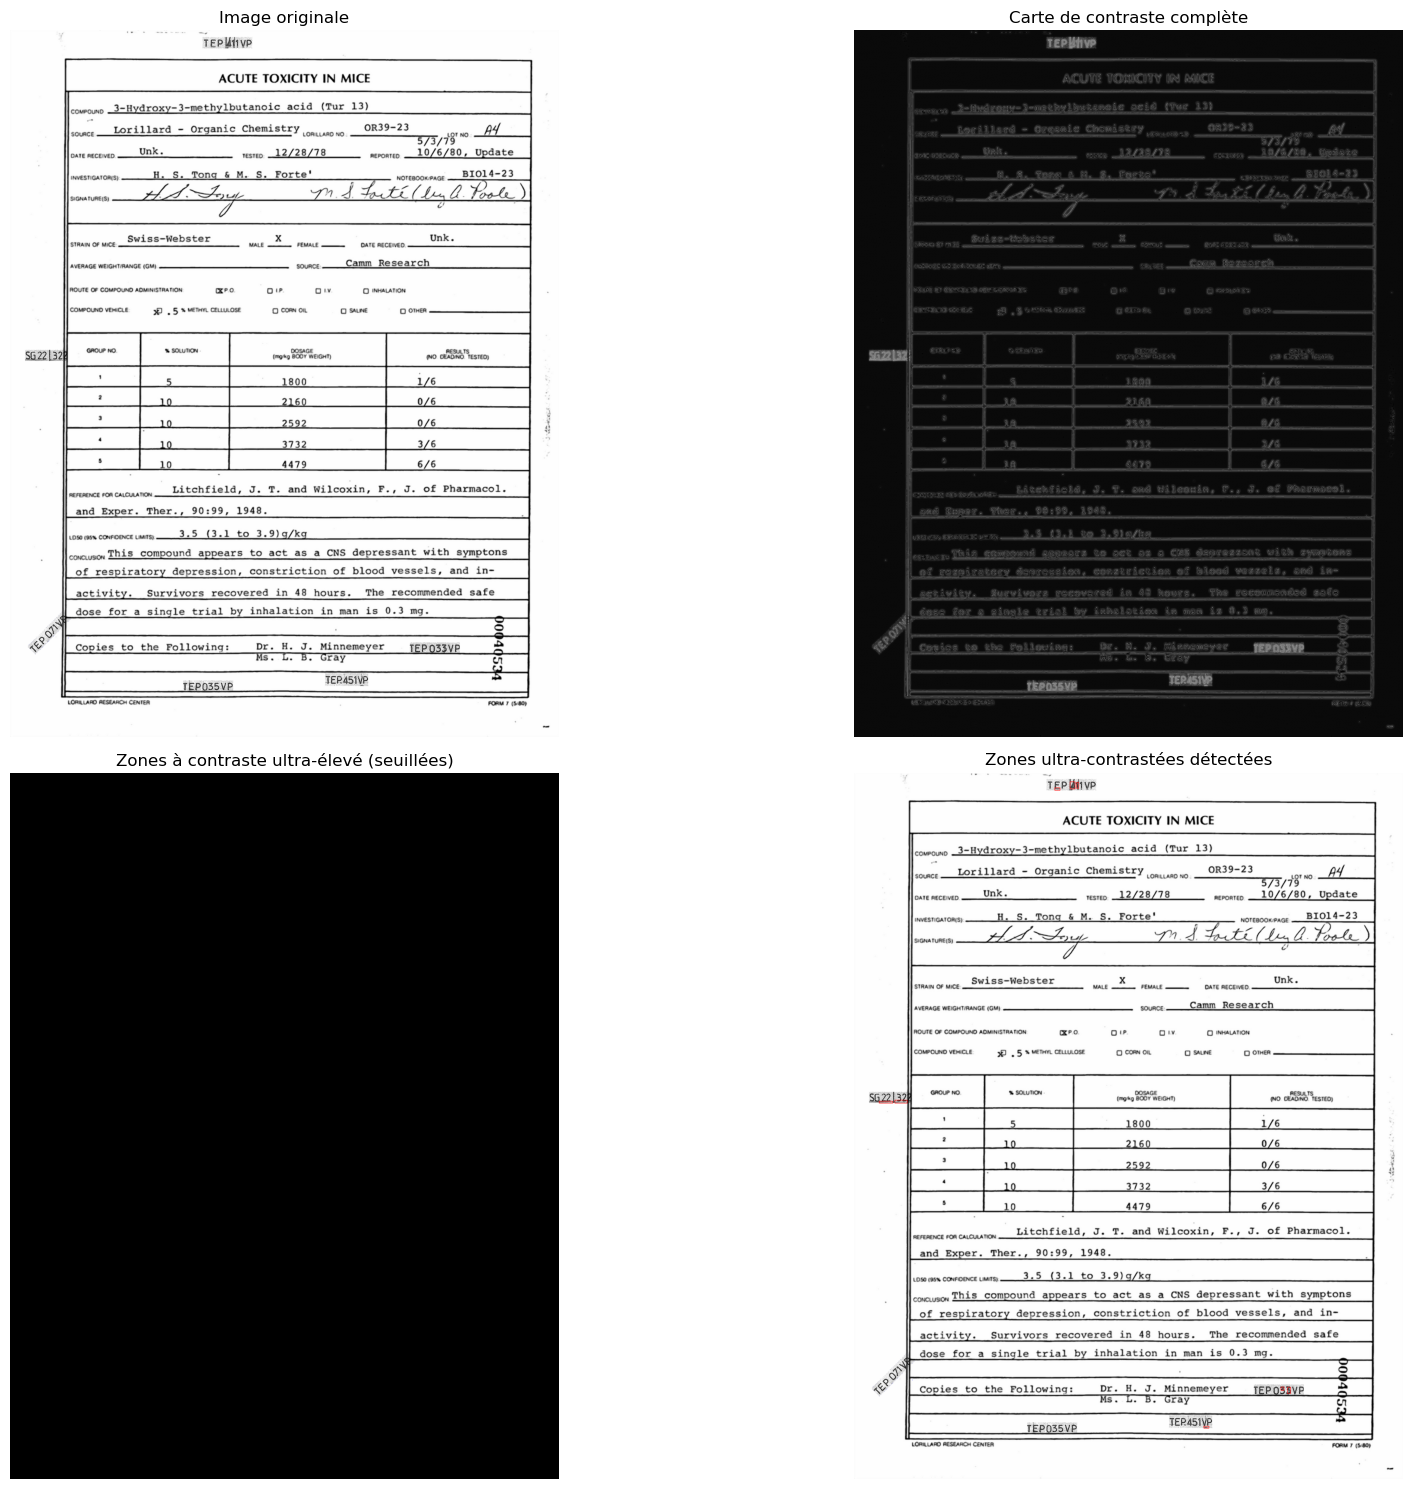

Résultat sauvegardé dans resultat_ultra_contraste_2.png


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.measure import label, regionprops

def detect_ultra_white_contrast_zones(image_path, output_path=None):
    """
    Détecte et encadre les zones ultra-blanches (à très fort contraste) dans une image.
    
    Args:
        image_path (str): Chemin vers l'image d'entrée
        output_path (str, optional): Chemin pour sauvegarder l'image résultante
        
    Returns:
        tuple: Image originale, image avec les zones encadrées, et carte de contraste
    """
    # Chargement de l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")
    
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calcul du contraste local
    window_size = 25
    local_thresh = threshold_local(gray, window_size, offset=10, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)
    
    # Normalisation du contraste pour visualisation
    contrast_norm = (contrast / np.max(contrast) * 255).astype(np.uint8)
    
    # MODIFICATION: Utilisation d'un seuil beaucoup plus élevé pour isoler uniquement les zones ultra-blanches
    # Utilisez un percentile plus élevé (ex: 95 ou 98)
    thresh_value = np.percentile(contrast, 99.9)  # Ajustez ce seuil pour cibler les zones ultra-blanches
    ultra_high_contrast = contrast > thresh_value
    
    # Filtrage morphologique pour nettoyer les zones détectées
    kernel = np.ones((2, 2), np.uint8)  # Noyau plus petit pour préserver les détails
    ultra_high_contrast = cv2.morphologyEx(ultra_high_contrast.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    # Étiquetage des composantes connexes
    labeled = label(ultra_high_contrast)
    
    # Création d'une copie de l'image pour y dessiner les rectangles
    result = image.copy()
    
    # Création d'une image pour visualiser les zones de contraste ultra-élevé
    ultra_contrast_vis = np.zeros_like(gray)
    ultra_contrast_vis[ultra_high_contrast] = 255
    
    # Parcours des régions détectées
    for region in regionprops(labeled):
        # Filtrage des régions trop petites (seuil plus bas pour capturer les petites zones ultra-contrastées)
        if region.area < 30:  # Seuil réduit pour inclure les petites zones très contrastées
            continue
            
        # Récupération des coordonnées du rectangle englobant
        minr, minc, maxr, maxc = region.bbox
        
        # Filtrer les régions extrêmement petites qui pourraient être du bruit
        height = maxr - minr
        width = maxc - minc
        if height < 3 or width < 3:
            continue
            
        # Dessin du rectangle
        cv2.rectangle(result, (minc, minr), (maxc, maxr), (0, 0, 255), 2)  # Rouge pour être plus visible
    
    # Sauvegarde de l'image résultante si un chemin est spécifié
    if output_path:
        cv2.imwrite(output_path, result)
    
    return image, result, contrast_norm, ultra_contrast_vis

def visualize_detailed_results(original, processed, contrast_map, ultra_contrast_vis):
    """
    Affiche les résultats détaillés de la détection avec visualisation des zones ultra-contrastées.
    """
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Image originale')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(contrast_map, cmap='gray')
    plt.title('Carte de contraste complète')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(ultra_contrast_vis, cmap='gray')
    plt.title('Zones à contraste ultra-élevé (seuillées)')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
    plt.title('Zones ultra-contrastées détectées')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


output_path = "resultat_ultra_contraste_2.png"  # Optionnel, pour sauvegarder le résultat

original, result, contrast_norm, ultra_contrast_vis = detect_ultra_white_contrast_zones(image_path, output_path)

# Afficher les résultats détaillés
visualize_detailed_results(original, result, contrast_norm, ultra_contrast_vis)

print(f"Résultat sauvegardé dans {output_path}")

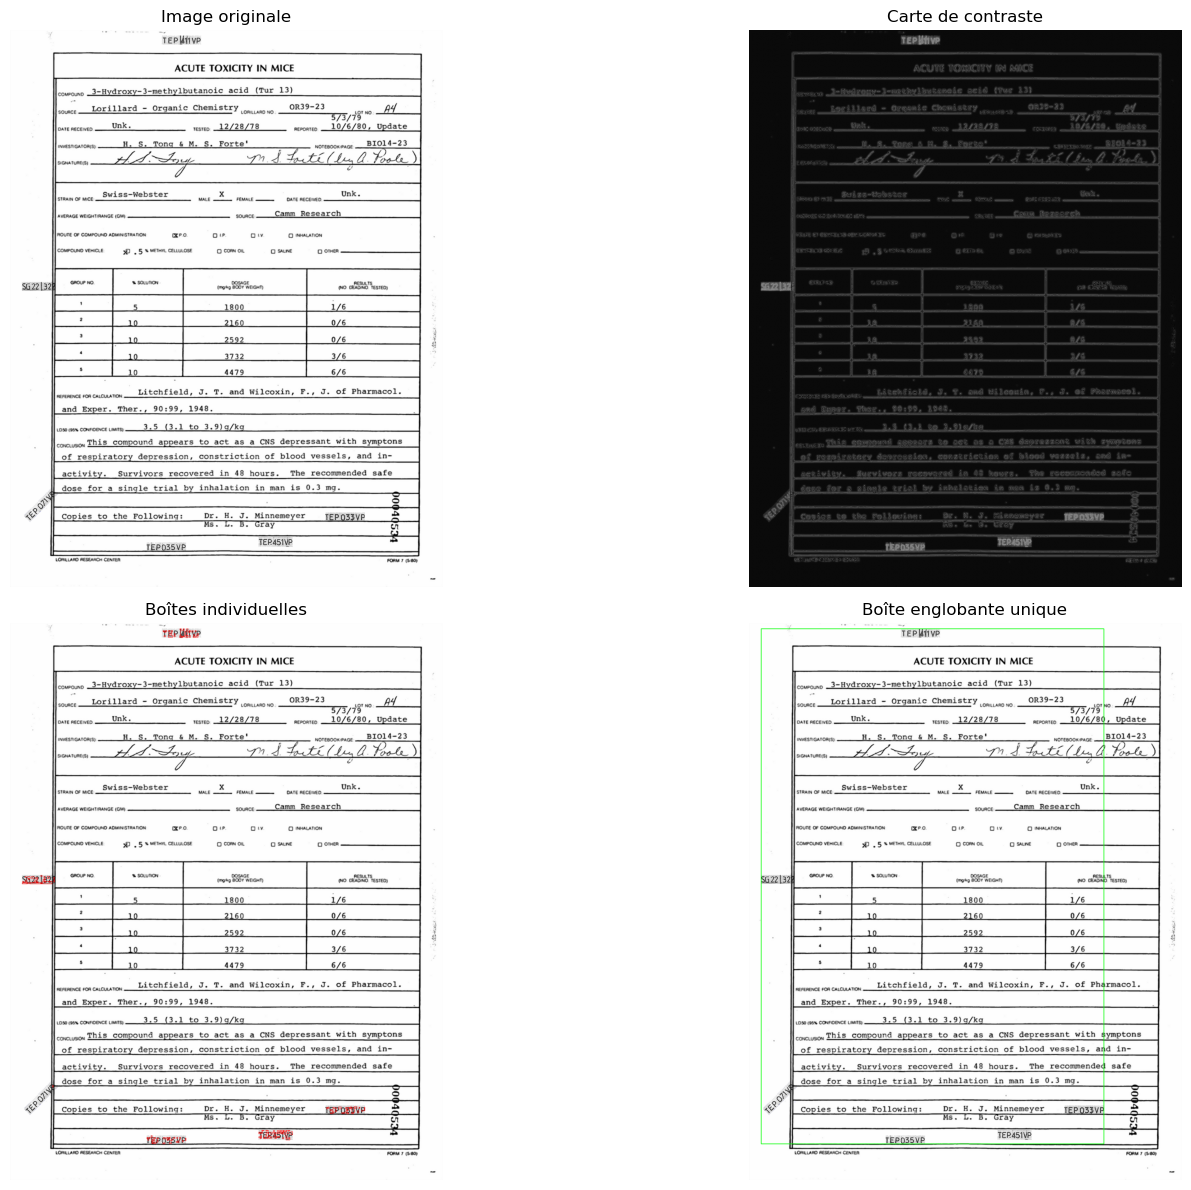

Résultat sauvegardé dans resultat_box_fusionnee.png


In [46]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.measure import label, regionprops

def merge_bounding_boxes(image_path, output_path=None):
    """
    Détecte les zones ultra-blanches puis regroupe toutes les boîtes 
    en une seule grande boîte englobante.
    
    Args:
        image_path (str): Chemin vers l'image d'entrée
        output_path (str, optional): Chemin pour sauvegarder l'image résultante
        
    Returns:
        tuple: Image originale et image avec la boîte englobante
    """
    # Chargement de l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")
    
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calcul du contraste local
    window_size = 25
    local_thresh = threshold_local(gray, window_size, offset=10, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)
    
    # Normalisation du contraste pour visualisation
    contrast_norm = (contrast / np.max(contrast) * 255).astype(np.uint8)
    
    # Seuillage pour les zones à contraste ultra-élevé
    thresh_value = np.percentile(contrast, 99.9)
    ultra_high_contrast = contrast > thresh_value
    
    # Filtrage morphologique
    kernel = np.ones((2, 2), np.uint8)
    ultra_high_contrast = cv2.morphologyEx(ultra_high_contrast.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    # Étiquetage des composantes connexes
    labeled = label(ultra_high_contrast)
    
    # Création d'une copie de l'image pour y dessiner les rectangles
    result_individual = image.copy()
    result_merged = image.copy()
    
    # Initialisation des coordonnées pour la boîte englobante globale
    global_min_x = float('inf')
    global_min_y = float('inf')
    global_max_x = 0
    global_max_y = 0
    
    # Liste pour stocker toutes les boîtes individuelles
    all_boxes = []
    
    # Parcours des régions détectées pour dessiner les boîtes individuelles
    for region in regionprops(labeled):
        # Filtrage des régions trop petites
        if region.area < 20:
            continue
            
        # Récupération des coordonnées du rectangle englobant
        min_y, min_x, max_y, max_x = region.bbox
        
        # Filtrer les boîtes trop petites
        if max_y - min_y < 3 or max_x - min_x < 3:
            continue
        
        # Ajouter à la liste des boîtes
        all_boxes.append((min_x, min_y, max_x, max_y))
        
        # Dessiner les boîtes individuelles
        cv2.rectangle(result_individual, (min_x, min_y), (max_x, max_y), (0, 0, 255), 2)
        
        # Mettre à jour les coordonnées globales
        global_min_x = min(global_min_x, min_x)
        global_min_y = min(global_min_y, min_y)
        global_max_x = max(global_max_x, max_x)
        global_max_y = max(global_max_y, max_y)
    
    # Vérifier si des boîtes ont été trouvées
    if all_boxes:
        # Dessiner la boîte englobante globale
        cv2.rectangle(result_merged, (global_min_x, global_min_y), 
                      (global_max_x, global_max_y), (0, 255, 0), 3)
    else:
        print("Aucune zone à fort contraste détectée")
    
    # Sauvegarde de l'image résultante avec la boîte fusionnée si un chemin est spécifié
    if output_path:
        cv2.imwrite(output_path, result_merged)
    
    return image, result_individual, result_merged, contrast_norm

def visualize_merged_boxes(original, individual_boxes, merged_box, contrast_map):
    """
    Affiche l'image originale, les boîtes individuelles et la boîte fusionnée.
    """
    plt.figure(figsize=(18, 12))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Image originale')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(contrast_map, cmap='gray')
    plt.title('Carte de contraste')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(cv2.cvtColor(individual_boxes, cv2.COLOR_BGR2RGB))
    plt.title('Boîtes individuelles')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(merged_box, cv2.COLOR_BGR2RGB))
    plt.title('Boîte englobante unique')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


output_path = "resultat_box_fusionnee.png"  # Optionnel, pour sauvegarder le résultat

original, individual_boxes, merged_box, contrast_norm = merge_bounding_boxes(image_path, output_path)

# Afficher les résultats
visualize_merged_boxes(original, individual_boxes, merged_box, contrast_norm)

print(f"Résultat sauvegardé dans {output_path}")

Initialisation d'EasyOCR...
Exécution de la reconnaissance OCR...


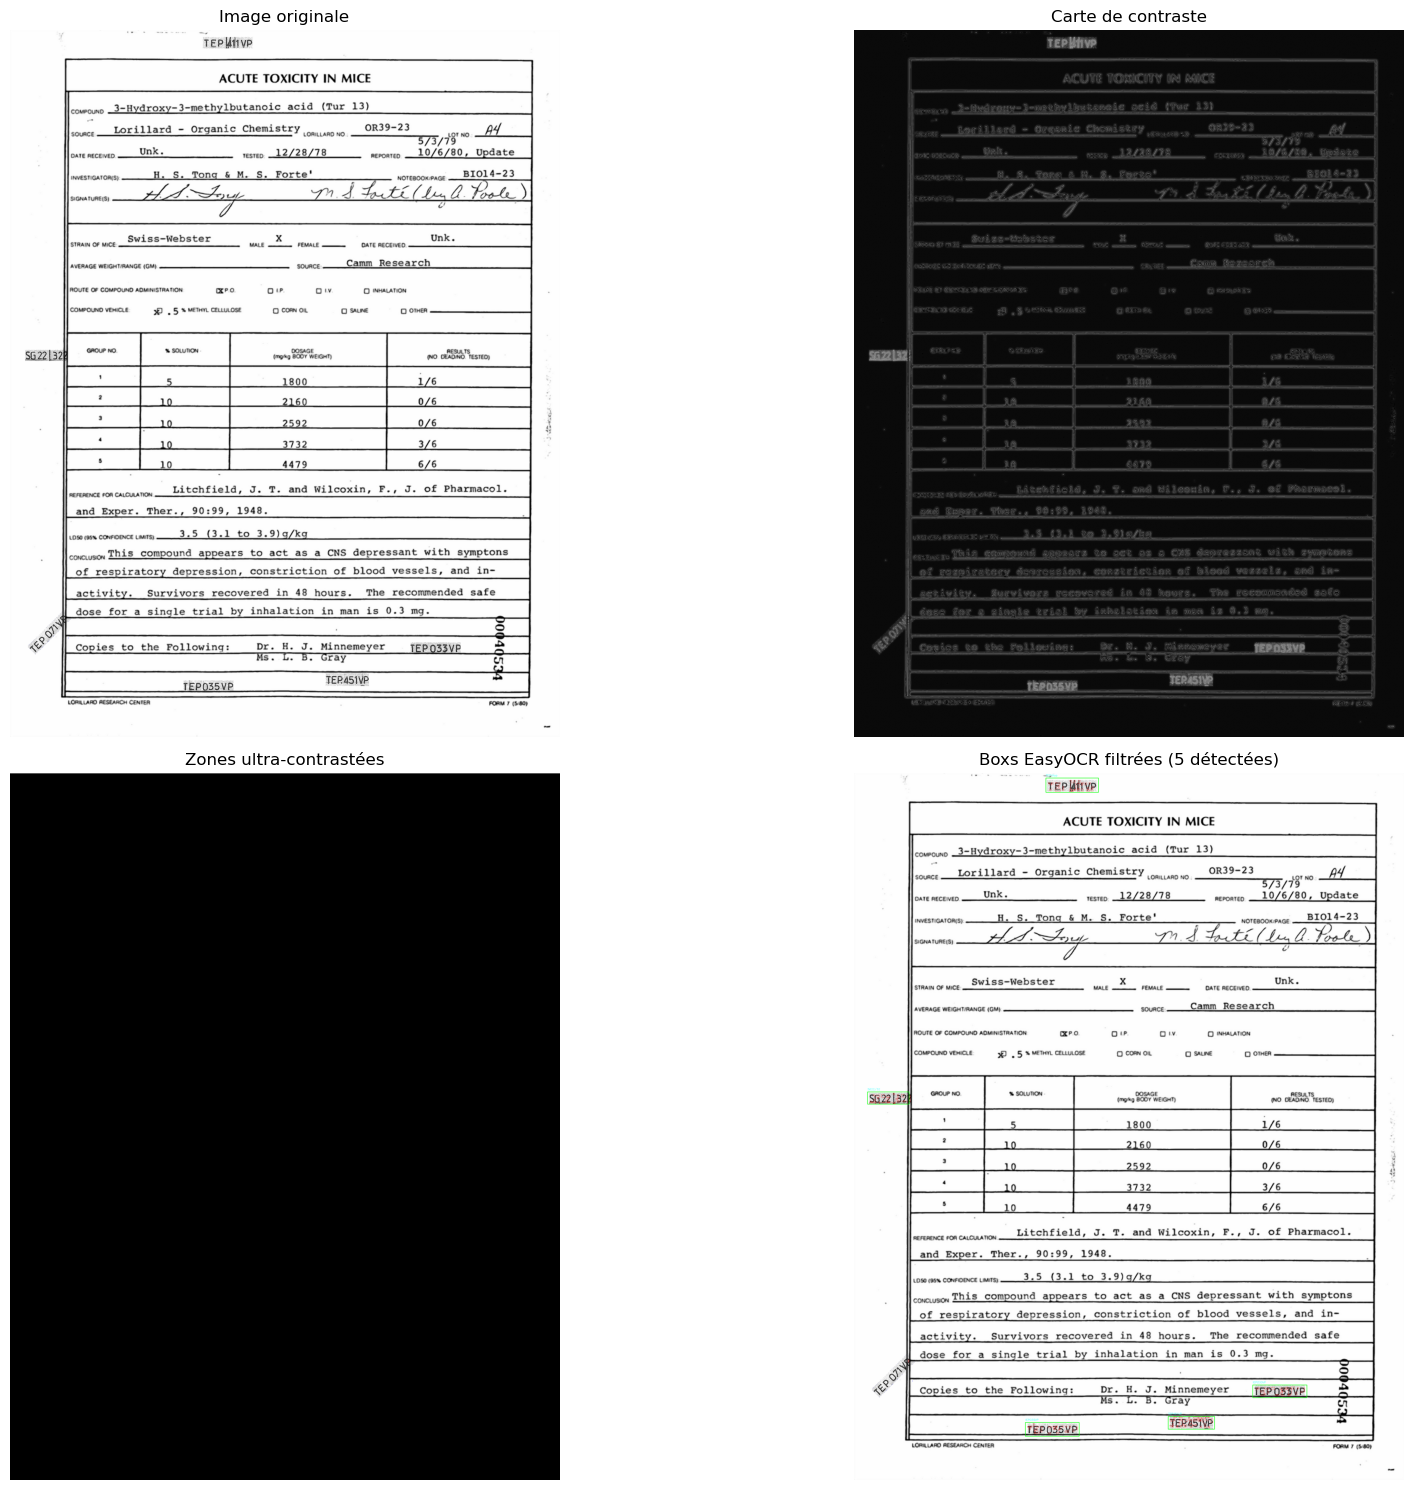


Textes reconnus dans les zones ultra-contrastées:
1. 'TEPUlIyp' (confiance: 0.32)
2. '5622/32' (confiance: 0.61)
3. 'IEPO33VP' (confiance: 0.90)
4. 'TEP451VP' (confiance: 0.61)
5. 'IEPO3SVP' (confiance: 0.87)
Résultat sauvegardé dans resultat_ocr_filtre.png
Nombre de zones de texte détectées après filtrage: 5


In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.measure import label, regionprops
import easyocr

def detect_ultra_white_zones_and_filter_ocr(image_path, output_path=None, languages=['fr']):
    """
    Détecte les zones ultra-contrastées, effectue l'OCR avec EasyOCR, puis filtre
    pour ne garder que les boxs EasyOCR qui intersectent les zones ultra-contrastées.
    
    Args:
        image_path (str): Chemin vers l'image d'entrée
        output_path (str, optional): Chemin pour sauvegarder l'image résultante
        languages (list): Liste des langues pour EasyOCR
        
    Returns:
        tuple: Image originale, image avec les boxs filtrées, et résultats OCR filtrés
    """
    # Chargement de l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")
    
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # --- PARTIE 1: DÉTECTION DES ZONES ULTRA-CONTRASTÉES ---
    
    # Calcul du contraste local
    window_size = 25
    local_thresh = threshold_local(gray, window_size, offset=10, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)
    
    # Normalisation du contraste pour visualisation
    contrast_norm = (contrast / np.max(contrast) * 255).astype(np.uint8)
    
    # Seuillage des zones ultra-contrastées
    thresh_value = np.percentile(contrast, 99.9)
    ultra_high_contrast = contrast > thresh_value
    
    # Filtrage morphologique pour nettoyer les zones détectées
    kernel = np.ones((2, 2), np.uint8)
    ultra_high_contrast = cv2.morphologyEx(ultra_high_contrast.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    # Étiquetage des composantes connexes
    labeled = label(ultra_high_contrast)
    
    # Stockage des rectangles des zones ultra-contrastées
    ultra_contrast_boxes = []
    ultra_contrast_vis = np.zeros_like(gray)
    ultra_contrast_vis[ultra_high_contrast] = 255
    
    # Récupération des boxs des zones ultra-contrastées
    for region in regionprops(labeled):
        if region.area < 20:
            continue
            
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width = maxc - minc
        
        if height < 3 or width < 3:
            continue
            
        # Stockage des coordonnées (format x1, y1, x2, y2)
        ultra_contrast_boxes.append([minc, minr, maxc, maxr])
    
    # --- PARTIE 2: DÉTECTION OCR AVEC EASYOCR ---
    
    print("Initialisation d'EasyOCR...")
    reader = easyocr.Reader(languages)
    print("Exécution de la reconnaissance OCR...")
    ocr_results = reader.readtext(image_path)
    
    # --- PARTIE 3: FILTRAGE DES BOXS OCR PAR INTERSECTION ---
    
    filtered_ocr_results = []
    
    # Fonction pour calculer l'intersection entre deux boxs
    def boxes_intersect(box1, box2):
        # box1, box2 format: x1, y1, x2, y2
        x1_1, y1_1, x2_1, y2_1 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        
        # Vérifier s'il y a intersection
        return not (x2_1 < x1_2 or x1_1 > x2_2 or y2_1 < y1_2 or y1_1 > y2_2)
    
    # Filtrer les résultats OCR qui intersectent au moins une zone ultra-contrastée
    for ocr_result in ocr_results:
        bbox, text, confidence = ocr_result
        
        # Conversion du format de box EasyOCR (points) au format x1,y1,x2,y2
        points = np.array(bbox).astype(int)
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)
        ocr_box = [x_min, y_min, x_max, y_max]
        
        # Vérifier si cette box OCR intersecte au moins une zone ultra-contrastée
        for ultra_box in ultra_contrast_boxes:
            if boxes_intersect(ocr_box, ultra_box):
                filtered_ocr_results.append(ocr_result)
                break
    
    # --- PARTIE 4: VISUALISATION DES RÉSULTATS ---
    
    # Création d'une copie de l'image pour les résultats
    result_image = image.copy()
    contrast_with_ocr = cv2.cvtColor(contrast_norm, cv2.COLOR_GRAY2BGR)
    
    # Dessin des boxs ultra-contrastées en rouge
    for box in ultra_contrast_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
    # Dessin des boxs OCR filtrées en vert
    for ocr_result in filtered_ocr_results:
        bbox, text, confidence = ocr_result
        points = np.array(bbox).astype(int)
        
        # Dessiner le polygone de la box OCR
        cv2.polylines(result_image, [points], True, (0, 255, 0), 2)
        
        # Dessiner les points d'intersection des zones OCR avec contraste
        for ultra_box in ultra_contrast_boxes:
            x1, y1, x2, y2 = ultra_box
            for point in points:
                px, py = point
                if x1 <= px <= x2 and y1 <= py <= y2:
                    cv2.circle(result_image, (px, py), 3, (255, 0, 0), -1)
        
        # Ajouter le texte reconnu
        x_min = points[:, 0].min()
        y_min = points[:, 1].min() - 10
        cv2.putText(result_image, text, (x_min, y_min), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
    
    # Sauvegarde de l'image résultante si un chemin est spécifié
    if output_path:
        cv2.imwrite(output_path, result_image)
    
    return image, result_image, filtered_ocr_results, contrast_norm, ultra_contrast_vis

def visualize_filtered_ocr_results(original, result, contrast_map, ultra_contrast_vis, filtered_results):
    """
    Affiche les résultats de la détection OCR filtrés par les zones ultra-contrastées.
    """
    plt.figure(figsize=(20, 15))
    
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title('Image originale')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(contrast_map, cmap='gray')
    plt.title('Carte de contraste')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(ultra_contrast_vis, cmap='gray')
    plt.title('Zones ultra-contrastées')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(f'Boxs EasyOCR filtrées ({len(filtered_results)} détectées)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des textes reconnus
    if filtered_results:
        print("\nTextes reconnus dans les zones ultra-contrastées:")
        for i, (_, text, confidence) in enumerate(filtered_results):
            print(f"{i+1}. '{text}' (confiance: {confidence:.2f})")


output_path = "resultat_ocr_filtre.png"

# Pour les langues françaises + anglaises
original, result, filtered_results, contrast_norm, ultra_contrast_vis = detect_ultra_white_zones_and_filter_ocr(
    image_path, 
    output_path,
    languages=['fr', 'en']  # Ajustez selon vos besoins
)

# Afficher les résultats
visualize_filtered_ocr_results(original, result, contrast_norm, ultra_contrast_vis, filtered_results)

print(f"Résultat sauvegardé dans {output_path}")
print(f"Nombre de zones de texte détectées après filtrage: {len(filtered_results)}")

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from skimage.measure import label, regionprops
import easyocr
import csv
import json
import os

def detect_and_save_to_csv(image_path, csv_output_path, output_image_path=None, languages=['fr']):
    """
    Détecte les zones ultra-contrastées, filtre les résultats OCR par intersection,
    et enregistre les résultats au format CSV sans guillemets en trop.
    
    Args:
        image_path (str): Chemin vers l'image d'entrée
        csv_output_path (str): Chemin pour enregistrer le fichier CSV
        output_image_path (str, optional): Chemin pour sauvegarder l'image résultante
        languages (list): Liste des langues pour EasyOCR
    """
    # Chargement de l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Impossible de charger l'image: {image_path}")
    
    # Générer un ID depuis le nom de fichier sans extension
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # --- PARTIE 1: DÉTECTION DES ZONES ULTRA-CONTRASTÉES ---
    
    # Calcul du contraste local
    window_size = 25
    local_thresh = threshold_local(gray, window_size, offset=10, method='gaussian')
    contrast = np.abs(gray.astype(np.float32) - local_thresh)
    
    # Seuillage des zones ultra-contrastées
    thresh_value = np.percentile(contrast, 99.9)
    ultra_high_contrast = contrast > thresh_value
    
    # Filtrage morphologique pour nettoyer les zones détectées
    kernel = np.ones((2, 2), np.uint8)
    ultra_high_contrast = cv2.morphologyEx(ultra_high_contrast.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    # Étiquetage des composantes connexes
    labeled = label(ultra_high_contrast)
    
    # Stockage des rectangles des zones ultra-contrastées
    ultra_contrast_boxes = []
    
    # Récupération des boxs des zones ultra-contrastées
    for region in regionprops(labeled):
        if region.area < 20:
            continue
            
        minr, minc, maxr, maxc = region.bbox
        height = maxr - minr
        width = maxc - minc
        
        if height < 3 or width < 3:
            continue
            
        # Stockage des coordonnées (format x1, y1, x2, y2)
        ultra_contrast_boxes.append([minc, minr, maxc, maxr])
    
    # --- PARTIE 2: DÉTECTION OCR AVEC EASYOCR ---
    
    print("Initialisation d'EasyOCR...")
    reader = easyocr.Reader(languages)
    print("Exécution de la reconnaissance OCR...")
    ocr_results = reader.readtext(image_path)
    
    # --- PARTIE 3: FILTRAGE DES BOXS OCR PAR INTERSECTION ---
    
    filtered_ocr_results = []
    
    # Fonction pour calculer l'intersection entre deux boxs
    def boxes_intersect(box1, box2):
        # box1, box2 format: x1, y1, x2, y2
        x1_1, y1_1, x2_1, y2_1 = box1
        x1_2, y1_2, x2_2, y2_2 = box2
        
        # Vérifier s'il y a intersection
        return not (x2_1 < x1_2 or x1_1 > x2_2 or y2_1 < y1_2 or y1_1 > y2_2)
    
    # Filtrer les résultats OCR qui intersectent au moins une zone ultra-contrastée
    for ocr_result in ocr_results:
        bbox, text, confidence = ocr_result
        
        # Conversion du format de box EasyOCR (points) au format x1,y1,x2,y2
        points = np.array(bbox).astype(int)
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)
        ocr_box = [x_min, y_min, x_max, y_max]
        
        # Vérifier si cette box OCR intersecte au moins une zone ultra-contrastée
        for ultra_box in ultra_contrast_boxes:
            if boxes_intersect(ocr_box, ultra_box):
                filtered_ocr_results.append(ocr_result)
                break
    
    # --- PARTIE 4: PRÉPARATION DES DONNÉES POUR CSV ---
    
    # Liste pour stocker les résultats au format demandé
    results_for_csv = []
    
    # Création d'une copie de l'image pour les résultats
    result_image = image.copy()
    
    # Dessin des boxs ultra-contrastées en rouge
    for box in ultra_contrast_boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
    # Traitement de chaque résultat OCR filtré
    for ocr_result in filtered_ocr_results:
        bbox, text, confidence = ocr_result
        points = np.array(bbox).astype(int)
        
        # Calculer la boîte englobante rectangulaire
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)
        
        # Création d'un dictionnaire pour ce résultat
        result_dict = {
            "box": [int(x_min), int(y_min), int(x_max), int(y_max)],
            "text": text
        }
        
        # Ajouter à la liste des résultats
        results_for_csv.append(result_dict)
        
        # Dessiner le polygone de la box OCR sur l'image
        cv2.polylines(result_image, [points], True, (0, 255, 0), 2)
        
        # Ajouter le texte reconnu
        cv2.putText(result_image, text, (x_min, y_min - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)
    
    # --- PARTIE 5: ENREGISTREMENT DES RÉSULTATS ---
    
    # Enregistrement de l'image annotée si un chemin est spécifié
    if output_image_path:
        print(f"Enregistrement de l'image annotée dans {output_image_path}")
        cv2.imwrite(output_image_path, result_image)
    
    # MÉTHODE 1: Écriture directe dans un fichier texte au format souhaité
    with open(csv_output_path, 'w', encoding='utf-8') as f:
        # Convertir la liste de dictionnaires en JSON sans échappement
        results_json = json.dumps(results_for_csv)
        # Écrire la ligne au format exact demandé
        f.write(f"{image_id},{results_json}")
    
    print(f"Résultats enregistrés dans {csv_output_path}")
    print(f"Nombre de zones de texte détectées après filtrage: {len(results_for_csv)}")
    
    return result_image, results_for_csv

def process_multiple_images(image_directory, output_directory, languages=['fr']):
    """
    Traite plusieurs images d'un répertoire et crée un fichier CSV par image.
    
    Args:
        image_directory (str): Répertoire contenant les images à traiter
        output_directory (str): Répertoire pour sauvegarder les résultats CSV et images annotées
        languages (list): Liste des langues pour EasyOCR
    """
    # Création du répertoire de sortie s'il n'existe pas
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    
    # Extensions d'image à traiter
    image_extensions = ['.png', '.jpg', '.jpeg', '.tiff', '.bmp']
    
    # Parcourir les fichiers du répertoire
    for filename in os.listdir(image_directory):
        # Vérifier si c'est une image
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_path = os.path.join(image_directory, filename)
            image_id = os.path.splitext(filename)[0]
            
            # Définir les chemins de sortie
            csv_output_path = os.path.join(output_directory, f"{image_id}.csv")
            output_image_path = os.path.join(output_directory, f"annotated_{filename}")
            
            try:
                print(f"Traitement de l'image {filename}...")
                detect_and_save_to_csv(
                    image_path,
                    csv_output_path,
                    output_image_path,
                    languages
                )
            except Exception as e:
                print(f"Erreur lors du traitement de {filename}: {e}")

def combine_csv_files(csv_directory, output_csv_path):
    """
    Combine plusieurs fichiers CSV en un seul.
    
    Args:
        csv_directory (str): Répertoire contenant les fichiers CSV à combiner
        output_csv_path (str): Chemin du fichier CSV combiné
    """
    # Liste pour stocker toutes les lignes
    all_lines = []
    
    # Parcourir tous les fichiers CSV du répertoire
    for filename in os.listdir(csv_directory):
        if filename.endswith('.csv'):
            csv_path = os.path.join(csv_directory, filename)
            with open(csv_path, 'r', encoding='utf-8') as f:
                line = f.read().strip()
                if line:  # Si le fichier n'est pas vide
                    all_lines.append(line)
    
    # Écrire toutes les lignes dans un seul fichier
    with open(output_csv_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(all_lines))
    
    print(f"Tous les résultats ont été combinés dans {output_csv_path}")

# # Pour traiter une seule image
# csv_output_path = "resultats_ocr.csv"
# output_image_path = "image_annotee.png"

# result_image, results = detect_and_save_to_csv(
# image_path, 
# csv_output_path,
# output_image_path,
# languages=['fr', 'en']  # Ajustez selon vos besoins
# )

# # Affichage de l'image annotée
# plt.figure(figsize=(10, 8))
# plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
# plt.title(f'Résultat: {len(results)} zones de texte détectées')
# plt.axis('off')
# plt.show()

# Pour traiter plusieurs images et combiner les résultats
process_multiple_images(
    "intelligent-text-extraction/test/images", 
    "annotations_axel",
    languages=['fr', 'en']
)
combine_csv_files("submission_axel", "siregalant_v0.csv")

Traitement de l'image 01073843.png...
Initialisation d'EasyOCR...
Exécution de la reconnaissance OCR...
Enregistrement de l'image annotée dans annotations_axel/annotated_01073843.png
Résultats enregistrés dans annotations_axel/01073843.csv
Nombre de zones de texte détectées après filtrage: 4
Traitement de l'image 91315069_91315070.png...
Initialisation d'EasyOCR...
Exécution de la reconnaissance OCR...
Enregistrement de l'image annotée dans annotations_axel/annotated_91315069_91315070.png
Résultats enregistrés dans annotations_axel/91315069_91315070.csv
Nombre de zones de texte détectées après filtrage: 4
Traitement de l'image 91355841.png...
Initialisation d'EasyOCR...
Exécution de la reconnaissance OCR...
Enregistrement de l'image annotée dans annotations_axel/annotated_91355841.png
Résultats enregistrés dans annotations_axel/91355841.csv
Nombre de zones de texte détectées après filtrage: 8
Traitement de l'image 92081358_1359.png...
Initialisation d'EasyOCR...
Exécution de la reconna

In [ ]:
import cv2
import numpy as np

# Charger l'image en niveaux de gris
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Augmenter le contraste avec une égalisation d'histogramme
image_eq = cv2.equalizeHist(image)

# Appliquer un flou Gaussien pour lisser le bruit avant seuillage
image_blur = cv2.GaussianBlur(image_eq, (5, 5), 0)

# Appliquer un seuillage strict pour éliminer les zones grises (renforce "noir sur blanc")
_, binary_strict = cv2.threshold(image_blur, 200, 255, cv2.THRESH_BINARY)

# Seuillage Otsu pour détecter les zones les plus contrastées
_, binary_otsu = cv2.threshold(image_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Combiner les deux seuillages pour ne garder que les zones les plus nettes
binary = cv2.bitwise_and(binary_strict, binary_otsu)

# Appliquer une ouverture morphologique pour éliminer les petits bruits
kernel = np.ones((3, 3), np.uint8)
morph = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

# Détection des contours
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Charger l'image en couleur pour affichage des bounding boxes
image_color = cv2.imread(image_path)

# Filtrer et dessiner les zones détectées
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    
    # Vérifier l'intensité moyenne de la zone détectée pour exclure les zones trop grises
    roi = image[y:y+h, x:x+w]
    mean_intensity = np.mean(roi)
    
    if w > 50 and h > 10 and mean_intensity < 250:  # Exclure les zones plus claires
        cv2.rectangle(image_color, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Enregistrer l'image avec les zones détectées
cv2.imwrite("resultat_filtre.png", image_color)

print("Image enregistrée sous 'resultat_filtre.png'")

Image enregistrée sous 'resultat_filtre.png'


In [ ]:
def preprocess_image(image_path):
    """
    Preprocess image to improve text recognition
    """
    # Read image using cv2
    image = cv2.imread(image_path)
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Denoise
    denoised = cv2.fastNlMeansDenoising(gray)
    
    # Adaptive thresholding
    binary = cv2.adaptiveThreshold(
        denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 11, 2
    )
    
    # Dilate to strengthen characters
    kernel = np.ones((1, 1), np.uint8)
    dilated = cv2.dilate(binary, kernel, iterations=1)
    
    return dilated

def detect_text_regions(image):
    """
    Detect text regions in the image using MSER
    """
    # Create MSER object
    mser = cv2.MSER_create()
    
    # Detect regions
    regions, _ = mser.detectRegions(image)
    
    # Create mask to visualize regions
    mask = np.zeros(image.shape, dtype=np.uint8)
    for region in regions:
        hull = cv2.convexHull(region.reshape(-1, 1, 2))
        cv2.drawContours(mask, [hull], -1, (255, 255, 255), -1)
    
    return mask

def enhanced_easyocr_recognition(image_path, language='en'):
    """
    Enhanced OCR using EasyOCR with preprocessing
    
    Returns:
    list: A list of tuples containing bounding boxes, text, and confidence scores
    """
    # Preprocess the image
    processed_image = preprocess_image(image_path)
    
    # Initialize reader
    reader = easyocr.Reader([language], gpu=False)
    
    # Detect text regions
    text_regions = detect_text_regions(processed_image)
    
    # Perform OCR
    results = reader.readtext(processed_image)
    
    return results, processed_image, text_regions

def transform_enhanced_result(results, min_confidence=0.5):
    """
    Transform OCR results into Challenge's JSON format with confidence filtering
    """
    form_data = []
    for idx, (bbox, text, prob) in enumerate(results):
        # Only include results above confidence threshold
        if prob < min_confidence:
            continue
            
        # Convert bounding box coordinates to integers
        bbox = [[int(coord) for coord in point] for point in bbox]
        box_extracted = [bbox[0], bbox[2]]
        flat_box = [coord for sublist in box_extracted for coord in sublist]
        
        # Create the structure for each element
        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  # Default label
            "words": [{
                "box": flat_box,
                "text": text
            }],
            "linking": [],
            "id": idx,
            "confidence": float(prob)  # Add confidence score
        }
        
        form_data.append(item)

    return {"form": form_data}

def visualize_results(image_path, results, processed_image=None, text_regions=None):
    """
    Visualize the OCR results and preprocessing steps
    """
    # Create subplot
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    
    # Original image
    original = Image.open(image_path)
    axes[0,0].imshow(original)
    axes[0,0].set_title('Original Image')
    
    # Processed image
    if processed_image is not None:
        axes[0,1].imshow(processed_image, cmap='gray')
        axes[0,1].set_title('Processed Image')
    
    # Text regions
    if text_regions is not None:
        axes[1,0].imshow(text_regions, cmap='gray')
        axes[1,0].set_title('Detected Text Regions')
    
    # Results visualization
    result_img = original.copy()
    draw = ImageDraw.Draw(result_img)
    
    for (bbox, text, prob) in results:
        points = np.array(bbox).astype(np.int32)
        # Draw rectangle
        draw.polygon([tuple(point) for point in points], outline="red")
        # Add text and confidence
        draw.text((points[0][0], points[0][1] - 10), 
                 f"{text} ({prob:.2f})", 
                 fill="blue")
    
    axes[1,1].imshow(result_img)
    axes[1,1].set_title('OCR Results')
    
    plt.tight_layout()
    return fig

In [ ]:
# Example usage
results, processed_image, text_regions = enhanced_easyocr_recognition(image_path)
json_results = transform_enhanced_result(results)

# Visualize results
fig = visualize_results(image_path, results, processed_image, text_regions)
plt.show()

In [ ]:
import os
import json
import cv2
import pytesseract
from pytesseract import Output
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Configuration de Tesseract
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'  # Chemin vers l'exécutable Tesseract

def analyze_image(image_path: str, language: str = 'eng') -> list:
    """
    Analyze the image to detect text using Tesseract OCR.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    list: A list of dictionaries containing the bounding box, detected text, and confidence score for each detected text region.
    """
    # Lire l'image
    image = cv2.imread(image_path)
    # Utiliser Tesseract pour détecter le texte
    results = pytesseract.image_to_data(image, output_type=Output.DICT, lang=language)

    # Extraire les résultats
    n_boxes = len(results['level'])
    ocr_results = []
    for i in range(n_boxes):
        (x, y, w, h) = (results['left'][i], results['top'][i], results['width'][i], results['height'][i])
        text = results['text'][i]
        conf = int(results['conf'][i])
        if conf > 0:  # Filtrer les résultats avec une confiance > 0
            ocr_results.append({
                'bbox': [(x, y), (x + w, y), (x + w, y + h), (x, y + h)],
                'text': text,
                'conf': conf
            })

    return ocr_results

def transform_result(results: list) -> str:
    """
    Transforms OCR results into Challenge's JSON format.

    Args:
        results (list): A list of OCR results where each result is a dictionary containing:
            - bbox (list): Bounding box coordinates.
            - text (str): Detected text.
            - conf (int): Confidence score.

    Returns:
        str: A JSON string representing the transformed OCR results.
    """
    form_data = []
    for idx, result in enumerate(results):
        bbox = result['bbox']
        text = result['text']
        box_extracted = [bbox[0], bbox[2]]
        flat_box = [coord for sublist in box_extracted for coord in sublist]

        item = {
            "box": flat_box,
            "text": text,
            "label": "RF",  # Customize this field as needed
            "words": [{"box": flat_box, "text": text}],
            "linking": [],
            "id": idx
        }
        form_data.append(item)

    json_data = {
        "form": form_data
    }

    return json_data

def draw_boxes(image: Image, annotation: dict) -> Image:
    """
    Draw bounding boxes on the image based on the annotation.

    Parameters:
    image (Image): The input image.
    annotation (dict): The annotation containing bounding boxes and text.

    Returns:
    Image: The image with bounding boxes drawn.
    """
    image_with_boxes = image.copy()
    draw = ImageDraw.Draw(image_with_boxes)

    system_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
    sans_serif_font = next((f for f in system_fonts if 'sans' in f.lower()), None)

    if sans_serif_font:
        font = ImageFont.truetype(sans_serif_font, 30)
    else:
        print("No suitable font found, using default")
        font = ImageFont.load_default()

    for dict_box in annotation['form']:
        text = dict_box['text']
        (x_min, y_min, x_max, y_max) = dict_box['box']
        if x_min < x_max and y_min < y_max:
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            draw.text((x_min, y_min - 30), f"{text}", fill="blue", font=font)
        else:
            print(f"Bounding box is invalid: {dict_box['box']}")

    return image_with_boxes

# Exemple d'utilisation
results = analyze_image(image_path)
json_results = transform_result(results)
print(json.dumps(json_results, indent=4, ensure_ascii=False))

# Afficher l'image avec les bounding boxes
image = Image.open(image_path)
image_with_boxes = draw_boxes(image, json_results)
plt.imshow(image_with_boxes)
plt.show()


# 7. Example of a Random Submission

In [ ]:
def submit():
    start_path = "/kaggle/input/intelligent-text-extraction/test/images"
    
    dataframe_liste = []
    for root, dirs, files in os.walk(start_path):
        for file in files:
            image_path = os.path.join(root, file)
            image_id = os.path.basename(image_path).split(".")[0]
            image = Image.open(image_path)
    
            ### change code here to incorporate your predictions
            box = list(np.random.randint(0, 4000, 4))
            text = "ETY017359D3"
            ###
            
            target = [{'box': box, 'text': text}]
            target_tocsv = str(target).replace(',', ';')
            line = {"id": image_id, "target": target_tocsv, "Usage": "Public"}
            dataframe_liste.append(line)
    
    df = pd.DataFrame(dataframe_liste)
    df.to_csv("submission.csv", index=False)

submit()